##                                                          Système de Recommandation - MovieLens



Dans ce projet, nous développons un système de recommandation de films à partir du jeu de données MovieLens 100K, fourni par le laboratoire GroupLens de l’Université du Minnesota. Ce jeu contient environ 100 000 évaluations explicites (notes de 1 à 5) attribuées par 943 utilisateurs à 1 682 films, ce qui en fait une base de référence reconnue pour les expérimentations en apprentissage automatique appliquées à la recommandation.

L’objectif métier est d’améliorer l’expérience utilisateur en proposant à chaque spectateur une sélection de films personnalisés, favorisant ainsi une meilleure rétention et satisfaction. Plus précisément, notre modèle doit générer les 5 meilleures recommandations de films pour un utilisateur donné, sur la base de ses évaluations passées.

La préparation des données a impliqué le nettoyage des valeurs manquantes, la structuration des interactions utilisateur–film et la séparation des ensembles d’entraînement et de test. Nous avons utilisé principalement pandas pour la manipulation des données et scikit-learn pour la gestion des métriques et de la validation.

Pour la modélisation, nous avons privilégié le filtrage collaboratif en implémentant la factorisation matricielle via l’algorithme SVD (Singular Value Decomposition), grâce à la bibliothèque Surprise. Le réglage des hyperparamètres a été effectué par GridSearchCV, en testant différentes valeurs de nombre de facteurs latents, taux d’apprentissage et régularisation.

Les performances du modèle ont été évaluées via RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error), avec une validation croisée en k-plis. Notre modèle final atteint un RMSE de [valeur] et un MAE de [valeur], indiquant une bonne capacité de prédiction des préférences.

Enfin, nous générons pour chaque utilisateur une liste de recommandations personnalisées. Des limites persistent, notamment le problème du démarrage à froid pour les nouveaux utilisateurs/films. En perspective, nous suggérons d’intégrer un filtrage basé sur le contenu afin de pallier ces limitations et d’améliorer encore la pertinence des suggestions.

---



## Plan de travail

1. Chargement et exploration du dataset MovieLens
2. Préparation des données
3. Modélisation – Filtrage collaboratif (SVD)
4. Évaluation des performances
5. Recommandations personnalisées
6. Conclusion

---



## 1.0 Chargement des bibliothèques

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn


np.random.seed(1)

## 1.1 Chargement des fichiers de données

**_Nous allons charger les fichiers_**:
1. **_movies.csv_** ==> les movieId, titres et genres (très utile pour les reco. de façon lisible)
2. **_ratings.csv_** ==> les userId, movieId, ratings et timestamp (cœur du système de reco)

Nous utilisons ces fichies selon notre objectifs qui est de " **_générer les 5 meilleures recommandations de films pour un utilisateur donné, sur la base de ses évaluations passées_**  "

**Info**: les fichiers ce trouvent dans le dosier " **_ml-latest-small_** "

In [39]:
#chargerons et fusionnons les fichiers
movies = pd.read_csv("ml-latest-small/movies.csv", index_col=0)
ratings = pd.read_csv("ml-latest-small/ratings.csv", index_col=0)

#regrouppons les deux
df = pd.merge(movies,ratings, on="movieId")

#les cinqs premiers lignes
df.head()

,movieId,title,genres,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,1305696483


## 1.2 Explorons un peu le dataset

In [44]:
#verifions les types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   rating     100836 non-null  float64
 4   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [46]:
#verifions les valeus manquante
df.isnull().sum()

movieId      0
title        0
genres       0
rating       0
timestamp    0
dtype: int64

In [48]:
# Affichage des statistiques descriptives du DataFrame
df.describe()

,movieId,rating,timestamp
count,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,3.501557,1.205946e+09
std,35530.987199,1.042529,2.162610e+08
min,1.000000,0.500000,8.281246e+08
25%,1199.000000,3.000000,1.019124e+09
50%,2991.000000,3.500000,1.186087e+09
75%,8122.000000,4.000000,1.435994e+09
max,193609.000000,5.000000,1.537799e+09


In [94]:
# Affichage du nombre de valeurs uniques pour chaque variable
df.nunique()

movieId       9724
title         9719
genres         951
rating          10
timestamp    85043
dtype: int64

### Aller un peu plus loin

* On va analyser les genres des films les plus bien notée

<Figure size 1000x600 with 0 Axes>

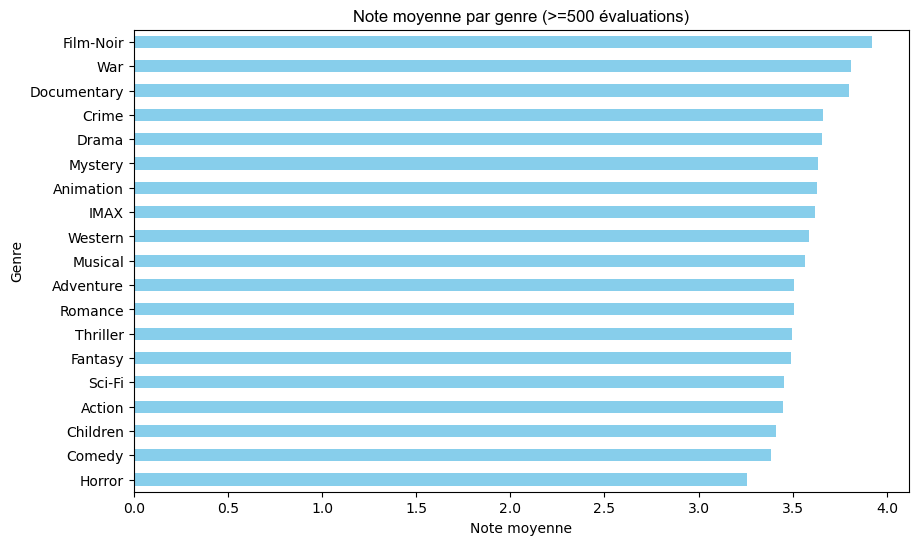

In [65]:
#Séparer les genres (chaque genre sur une ligne)
data_exploded = df.assign(genre=df["genres"].str.split("|")).explode("genre")

# Calcul des statistiques par genre
genre_stats = data_exploded.groupby("genre").agg(
    avg_rating=("rating", "mean"),
    count=("rating", "count")
).sort_values(by="avg_rating", ascending=False)

# Filtrer les genres ayant au moins 500 évaluations (évite les biais sur petits échantillons)
genre_stats_filtered = genre_stats[genre_stats["count"] >= 500]

# Visualisation
plt.figure(figsize=(10,6))
genre_stats_filtered.sort_values("avg_rating").plot(
    y="avg_rating", kind="barh", legend=False, color="skyblue", figsize=(10,6)
)
plt.title("Note moyenne par genre (>=500 évaluations)", fontname="Arial")
plt.xlabel("Note moyenne")
plt.ylabel("Genre")
plt.show()

### _Conclusion_:
**_Après l'analyse sur les genres, on trouve que ces trois (Film-Noir, War, Documentary) types ont la chances d'etre présent dans les cinqs meilleures recommandation des film pour les utilisateurs. En basent sur ce jeux de donnée_**

## 2.0 Preparation des donnéé

* 2.1 **_Sélectionner les colonnes utiles_**

In [99]:
#Supprimons Timestamp
df_prep = df[["title", "genres", "rating"]]

#les cinqs premiers observations
df_prep.head()

,title,genres,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5


* 2.2 **_Pour prepearer les données on va utiliser "Surprise" qui est une bibliothèque Python spécialement conçue pour le filtrage collaboratif_**
   

1. Import " **_Surprise_**"
2. Creer un objet de "Surprise" avec **_Dataset, Reader_** et je vais définir l’échelle des notes (de 0.5 à 5).

In [116]:
from surprise import Dataset, Reader

#creation de l'objet
reader = Reader(rating_scale=(0.5,5))
dataset = Dataset.load_from_df(df_prep, reader)

* 2.3 **_Créer un jeu d’entraînement et test_**

In [123]:
from surprise.model_selection import train_test_split

#divise le je de donnée "dataset"
trainset, testset = train_test_split(dataset, test_size=0.2)

## 3.0 Modélisation – Filtrage collaboratif (SVD)

* 3.1 **_Pour cette projet et pour atteindre notre objectif, je vais utiliser "SVD" (Décomposition en Valeurs Singulières) est un algorithme de factorisation
de matrices qui est au cœur du filtrage collaboratif moderne_**


1. Importer **_"SVD"_**
2. Créer et fit l'objet de "SVD"

In [140]:
from surprise import SVD

#creation de l'objet
model = SVD()

#fit le model
model.fit(trainset)

## 4.0 Évaluation des performances

* 4.1 **_Nous allons utiliser "RMSE" (Root Mean Square Error), Qui va nous permettre de mesurer la différence moyenne entre les valeurs prédites par un modèle et les valeurs réelles observées._**

1. Importer **_Accuracy_** qui vient Surprise
2. Faire la prediction sur **_Testset_**

In [154]:
from surprise import accuracy

#la prediction
prediction = model.test(testset)

#Afficher l'accuracy
print("RMSE :" ,accuracy.rmse(prediction))

RMSE: 0.9526
RMSE : 0.9526104572127774


## 5.0 Recommandations personnalisées

* 5.1 **_Creation d'une fonction pour faire la recommandation de 5 meilleures films_**

In [188]:
def get_top5_recommendations(user_id, model, ratings, movies):
    # 1. Films déjà notés par l’utilisateur (accede index 'userId' nan ratings avec .loc)
    user_movies = ratings.loc[user_id]['movieId'].tolist()  # ratings.loc[user_id] retourne tous les films de l'user

    # 2. Films non notés: Accède index 'movieId' nan movies (se tout fim ki nan katalòg la)
    all_movies = movies.index.tolist()  # Itilize .index.tolist() pou pran tout index 'movieId' yo

    # 3. Fim ki poko note
    movies_to_predict = [m for m in all_movies if m not in user_movies]

    # 4. Prédictions
    predictions = [model.predict(user_id, m) for m in movies_to_predict]

    # 5. Top 5 ordonné
    top5 = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

    # 6. Kreye yon DataFrame ak resultat yo
    top5_movies = pd.DataFrame({
        'movieId': [pred.iid for pred in top5],        # ID fim yo
        'predicted_rating': [pred.est for pred in top5] # Evalyasyon prevwa yo
    })

    # 7. Melanje ak enfomasyon fim yo (title, genres)
    # Reyini index 'movieId' nan movies anvan melanj
    movies_reset = movies.reset_index()  # Sa ajoute 'movieId' kòm yon kolòn
    top5_with_details = top5_movies.merge(movies_reset, on='movieId')

    # 8. Retounen top 5 ak detay yo
    return top5_with_details[['title', 'genres', 'predicted_rating']]

# Exemple : recommandations pour l’utilisateur 200
print(get_top5_recommendations(200, model, ratings, movies))

                      title                      genres  predicted_rating
0            Jumanji (1995)  Adventure|Children|Fantasy          3.498959
1   Grumpier Old Men (1995)              Comedy|Romance          3.498959
2  Waiting to Exhale (1995)        Comedy|Drama|Romance          3.498959
3               Heat (1995)       Action|Crime|Thriller          3.498959
4            Sabrina (1995)              Comedy|Romance          3.498959


## 6.0 Conclusion

**Avec un RMSE d’environ 0.95, cela signifie que l’erreur moyenne du modèle est inférieure à une étoile sur l’échelle de notation (0.5 à 5.0). En d’autres termes, les prédictions du modèle sont globalement proches des évaluations réelles, même si des écarts ponctuels existent.**